In [11]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from scipy.misc import imread, imsave
from math import log
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [4]:
%matplotlib inline
sns.set_context("poster")

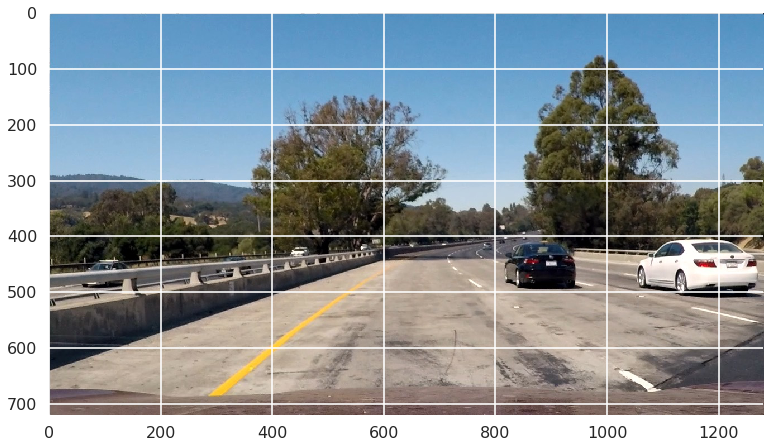

In [6]:
img = imread("test_images/test1.jpg")
plt.imshow(img)

In [12]:
img.shape

(720, 1280, 3)

In [13]:
#bring in camera calibration matrix
with open('udacity_project_4_camera_calibration.pkl', 'rb') as f:
    calibration = pickle.load(f)
mtx = calibration["mtx"]
dist = calibration["dist"]

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

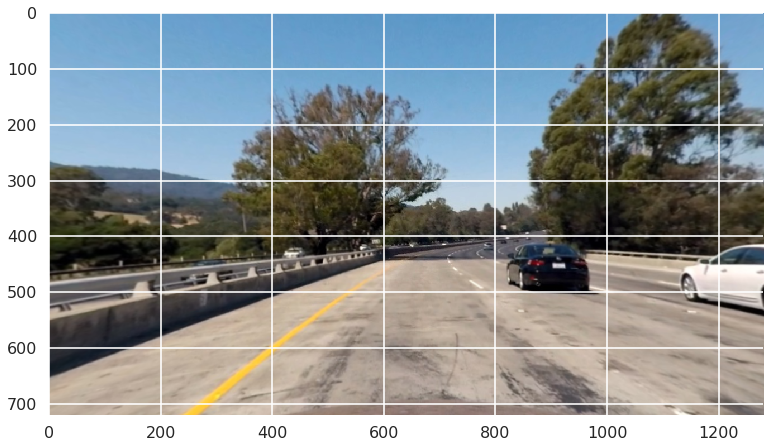

In [16]:
img = undistort(img)
plt.imshow(img)
imsave("output_images/pipeline_undistorted.jpg", img)

In [24]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255, sobel_kernel=3):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
      
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

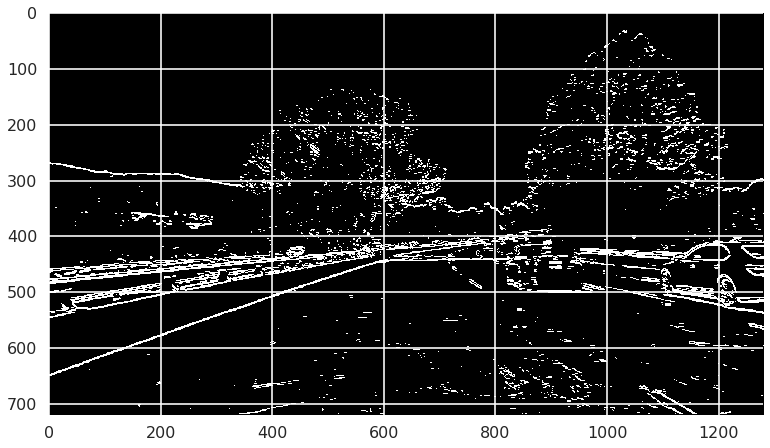

In [117]:
tmp = abs_sobel_thresh(img, 'y', 30,180)
plt.imshow(tmp, cmap="gray")

In [118]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude
    gradmag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_gradmag = np.uint8(255 * gradmag / np.max(gradmag))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_gradmag)
    # 6) Return this mask as your binary_output image
    binary_output[(scaled_gradmag >= mag_thresh[0]) & (scaled_gradmag <= mag_thresh[1])] = 1
    return binary_output

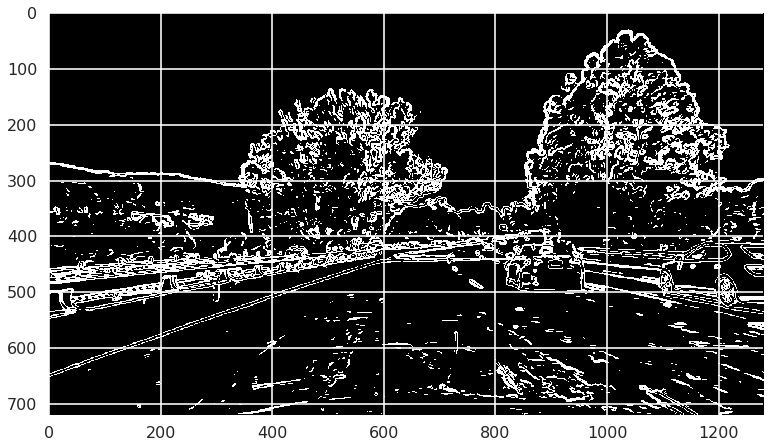

In [119]:
tmp = mag_thresh(img, 9, (30,100))
plt.imshow(tmp, cmap="gray")

In [28]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=9, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

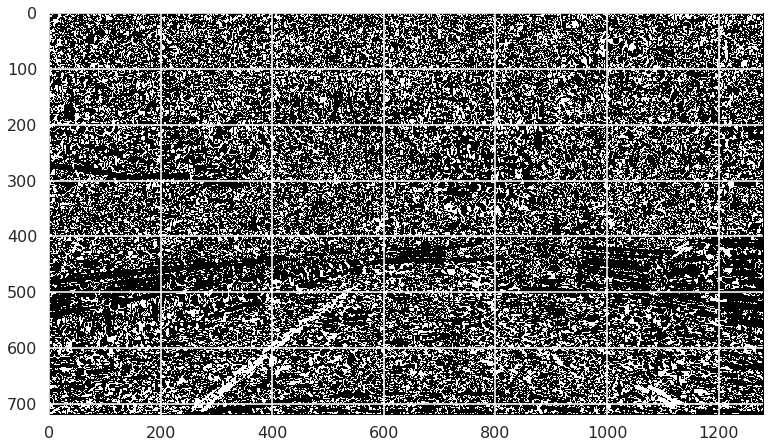

In [29]:
tmp = dir_threshold(img, 15, (.7,1.2))
plt.imshow(tmp, cmap="gray")

In [30]:
def color_threshold(img, h_thresh=(15, 100), s_thresh=(90, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    
    binary = np.zeros_like(S)
    binary[((S >= s_thresh[0]) & 
           (S <= s_thresh[1]))] = 1
    return binary


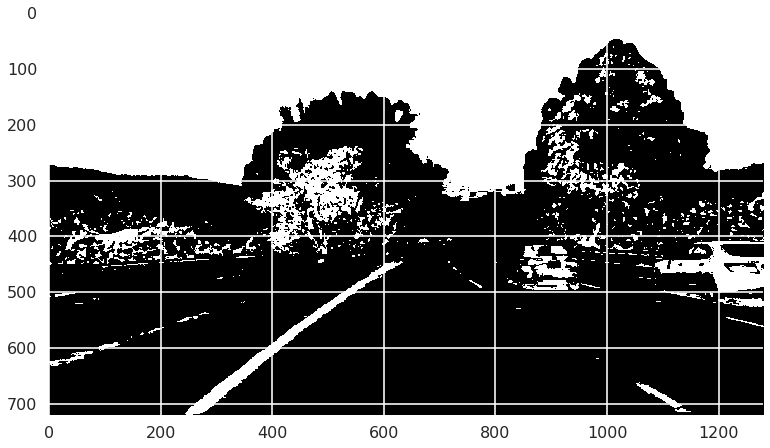

In [31]:
tmp=color_threshold(img)
plt.imshow(tmp, cmap="gray")

In [43]:
def hsv_threshold(img, v_thresh=(0,30)):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hsv[:,:,2]
    
    binary = np.zeros_like(S)
    binary[((S >= v_thresh[0]) & (S <= v_thresh[1]))] = 1
    return binary

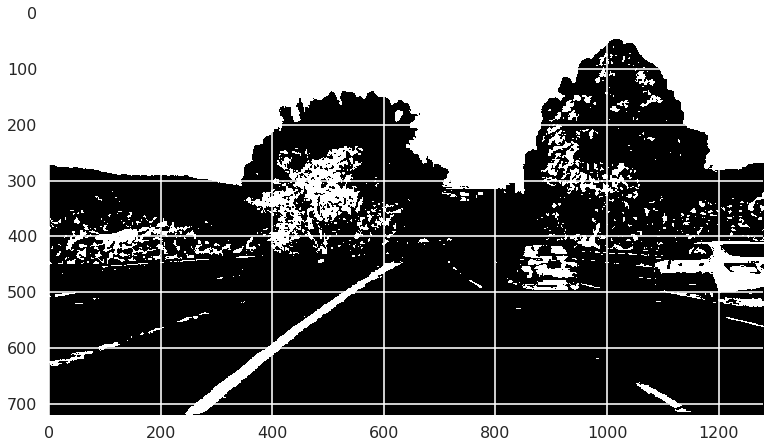

In [48]:
tmp = hsv_threshold(img, (0,90))
plt.imshow(tmp)

In [120]:
def find_lane_line(img):
    x_threshold = abs_sobel_thresh(img, 'x', 30, 120, 11)
    y_threshold = abs_sobel_thresh(img, 'y', 30, 180, 11)
    d_threshold = dir_threshold(img, 11, (.7,1.2))
    c_threshold = color_threshold(img)
#     v_threshold = hsv_threshold(, (0,90))
    
    binary = np.zeros_like(x_threshold)
    binary[((x_threshold == 1) | (y_threshold == 1) |(c_threshold == 1)) & (d_threshold == 1)] = 1
    return binary

In [121]:
l_width = 825 - 200
t_width = 637 - 464
midpoint_x = 200 + l_width/2

In [122]:
midpoint_x - t_width/2

426.0

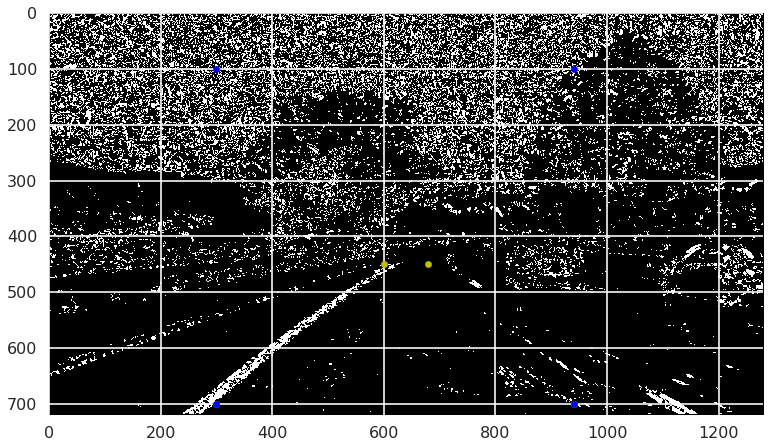

In [124]:
tmp = find_lane_line(img)
source_points = np.array([[600,450],[680,450],[300,700],[940,700]], dtype=np.float32)
dest_points = np.array([[300,100],[940,100],[300,700],[940,700]], dtype=np.float32)
plt.scatter(x=[x[0] for x in source_points], y=[x[1] for x in source_points], c='y', s=40)
plt.scatter(x=[x[0] for x in dest_points], y=[x[1] for x in dest_points], c='b', s=40)
M = cv2.getPerspectiveTransform(source_points, dest_points)
Minv = cv2.getPerspectiveTransform(dest_points, source_points)
img_size = (tmp.shape[1], tmp.shape[0])
warped = cv2.warpPerspective(tmp, M, img_size, flags=cv2.INTER_LINEAR )
plt.imshow(tmp, cmap="gray")

imsave("output_images/pipeline_binary.jpg", tmp)

In [202]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [203]:
warped.shape

(720, 1280)

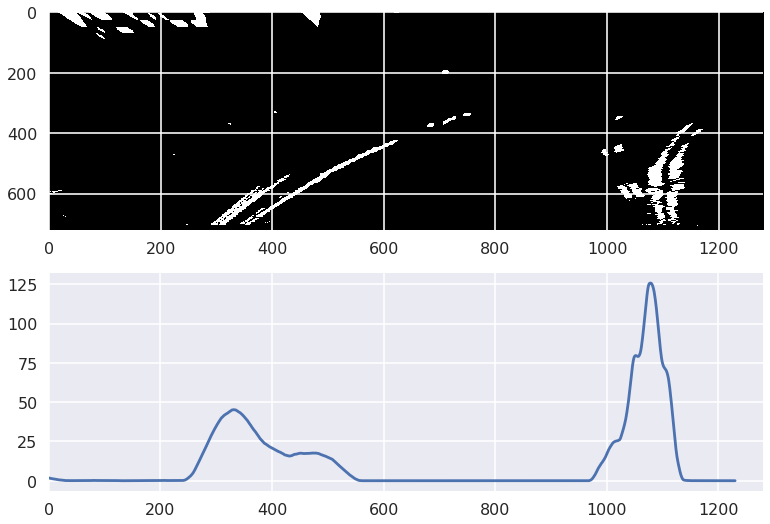

In [204]:
#take histogram of the lower third of the image
histogram = np.sum(warped[warped.shape[0]//3 * 2:,:], axis=0)
#smooth it out
histogram = moving_average(histogram, 50)

plt.subplot(2,1,1)
plt.imshow(warped, cmap="gray", aspect='auto')
plt.subplot(2,1,2)
plt.xlim((0,warped.shape[1]))
plt.plot(histogram)

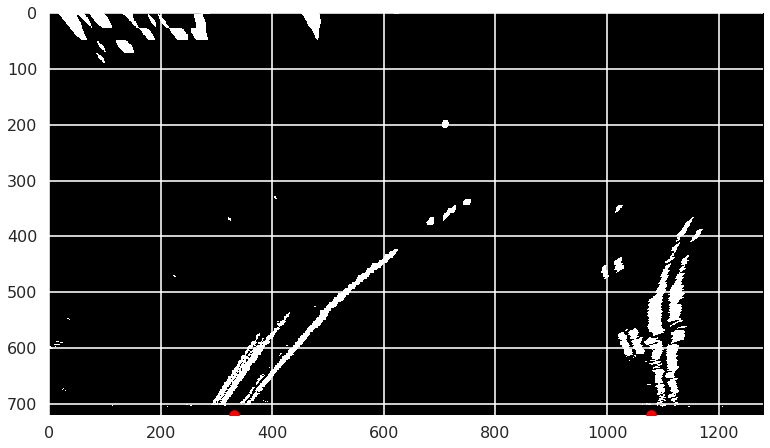

In [205]:

out_img = np.dstack((warped, warped, warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

max_y = out_img.shape[0]
plt.scatter(x=[leftx_base, rightx_base], y=[max_y,max_y], c='r', s=100)
plt.imshow(out_img)

In [221]:
# Set the number of sliding windows
nwindows = 30
# Set height of windows
window_height = np.int(warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

In [226]:
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 110
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

In [227]:
# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped.shape[0] - (window + 1) * window_height
    win_y_high = warped.shape[0] - window * window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


In [228]:
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

print('left fit', left_fit)
print('right fit', right_fit)

left fit [ -1.04745285e-03   1.59667971e-02   7.86926357e+02]
right fit [  1.37775966e-03  -1.58282773e+00   1.54266582e+03]


8198
10369


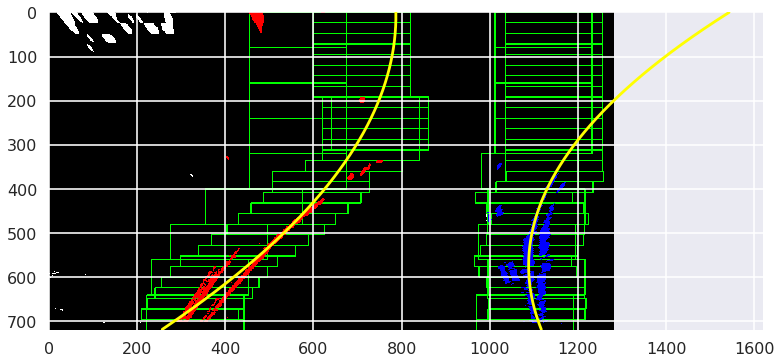

In [229]:
# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

print(len(nonzeroy[left_lane_inds]))
print(len(nonzeroy[right_lane_inds]))

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')





In [230]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

print(ym_per_pix, xm_per_pix)

y_eval = warped.shape[0]
print(y_eval)
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(nonzeroy[left_lane_inds]*ym_per_pix, nonzerox[left_lane_inds]*xm_per_pix, 2)
right_fit_cr = np.polyfit(nonzeroy[right_lane_inds]*ym_per_pix, nonzerox[right_lane_inds]*xm_per_pix, 2)

print("Left world fit", left_fit_cr )
print("Right world fit", right_fit_cr )
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

0.041666666666666664 0.005285714285714286
720
Left world fit [ -3.18904502e-03   2.02550226e-03   4.15946789e+00]
Right world fit [  4.19468770e-03  -2.00793004e-01   8.15409077e+00]
165.290921541 m 119.661701583 m


In [231]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

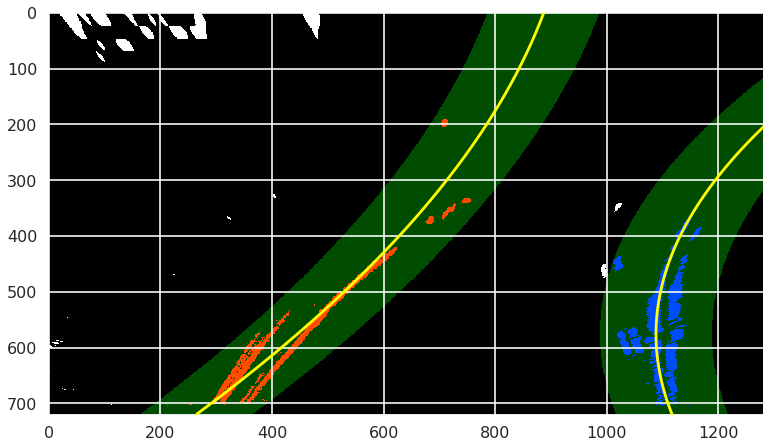

In [232]:
#Create an image to draw on and an image to show the selection window
out_img = np.dstack((warped, warped, warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [233]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

print(ym_per_pix, xm_per_pix)

y_eval = warped.shape[0]
print(y_eval)
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(nonzeroy[left_lane_inds]*ym_per_pix, nonzerox[left_lane_inds]*xm_per_pix, 2)
right_fit_cr = np.polyfit(nonzeroy[right_lane_inds]*ym_per_pix, nonzerox[right_lane_inds]*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

0.041666666666666664 0.005285714285714286
720
252.451508951 m 118.249251001 m


In [234]:
#calc offset
left_base_x = left_fitx[-1]
right_base_x = right_fitx[-1]
detected_center_x = (right_base_x - left_base_x)/2 + left_base_x
actual_center_x = result.shape[1]/2
lane_offset_pixels =  detected_center_x - actual_center_x
world_offset_pixels = lane_offset_pixels * xm_per_pix
print("pixel offset from center of lane", round(lane_offset_pixels, 3), 'px')
print("world offset from center of lane", round(world_offset_pixels, 3), 'm', round(world_offset_pixels * 3.28084, 3), "ft")

pixel offset from center of lane 51.068 px
world offset from center of lane 0.27 m 0.886 ft


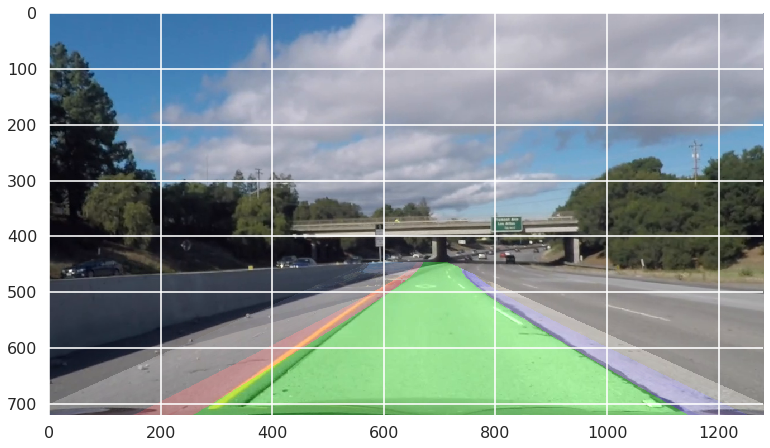

In [235]:
#make a nice output picture by mapping the lane back down
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([left_line_pts]), (255,0, 0))
cv2.fillPoly(color_warp, np.int_([right_line_pts]), (0,0, 255))
color_warp = cv2.addWeighted(img, 1, color_warp, 1, 1)


# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 
# Combine the result with the original image
final = cv2.addWeighted(img, 1, newwarp, 0.3, 0)




plt.imshow(final)

In [10]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, xm_per_pixel=3.7/700, ym_per_pixel=30/720, 
                 smoothing_frames=3, allowable_missed_frames = 3):
        # was the line detected in the last iteration?
        self.detected = False 
        self.missed_frames = 0
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        #polynomial coefficients for the most recent fit
        self.current_fit = np.zeros(3)
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = 0 
        #distance in meters of vehicle center from the line
        self.line_base_pos = 0 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        #x values for detected line pixels
        self.allx = []  
        #y values for detected line pixels
        self.ally = []
        
        self.smoothing_frames = smoothing_frames
        self.allowable_missed_frames = allowable_missed_frames
        
        # Define conversions in x and y from pixels space to meters
        self.xm_per_pix = xm_per_pixel # meters per pixel in x dimension
        self.ym_per_pix = ym_per_pixel # meters per pixel in y dimension
        
        
    def calc_curvature(self, y_point_used_to_calc_curvature):
        y_eval = y_point_used_to_calc_curvature
        
        if len(self.allx):
            # Fit new 2nd order polynomial to x,y in world space
            fit = np.polyfit(self.ally * self.ym_per_pix, self.allx * self.xm_per_pix, 2)

            # Calculate the new radii of curvature
            self.radius_of_curvature = ((1 + (2*fit[0]*y_eval*self.ym_per_pix + 
                               fit[1])**2)**1.5) / np.absolute(2*fit[0])

        #radius of curvature is in meters
        return self.radius_of_curvature
        
    def try_fit(self):
        # Fit a second order polynomial to each
        if len(self.allx):
            self.current_fit = np.polyfit(self.ally, self.allx, 2)
        return self.current_fit

    def predict_x(self, y):
        fit = self.current_fit
        return fit[0]*y**2 + fit[1]*y + fit[2]
        

In [72]:
class LanePositionDetector():
    def __init__(self, img_size, debug=True):
        self.left = Line()
        self.right = Line()
        self.current_offset = None
        self.curvature = None
        self.confidence = 0
        self.img_size = img_size # tuple(x, y)
        self.debug = debug
        self.debug_log = []
        
         #source points mapped from stright road in the center of the image 
        source_points = np.array([[600,450],[680,450],[300,700],[940,700]], dtype=np.float32)
        dest_points = np.array([[300,100],[940,100],[300,700],[940,700]], dtype=np.float32)

        #create transform matrices
        self.M = cv2.getPerspectiveTransform(source_points, dest_points)
        self.Minv = cv2.getPerspectiveTransform(dest_points, source_points)
        
        self.troubled_frames = []
        
    def color_threshold(self, img, h_thresh=(15, 100), s_thresh=(90, 255)):
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        S = hls[:,:,2]

        binary = np.zeros_like(S)
        binary[((S >= s_thresh[0]) & 
               (S <= s_thresh[1]))] = 1
        return binary
    
    def abs_sobel_thresh(sefl, img, orient='x', thresh_min=0, thresh_max=255, sobel_kernel=3):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        if orient == 'x':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
        if orient == 'y':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))

        # Scale to 8-bit (0 - 255) then convert to type = np.uint8
        scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
        
        # Create a mask of 1's where the scaled gradient magnitude 
        # is > thresh_min and < thresh_max
        binary_output = np.zeros_like(scaled_sobel)
        binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
        return binary_output
    
    def hsv_threshold(self, img, v_thresh=(0,30)):
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        S = hsv[:,:,2]

        binary = np.zeros_like(S)
        binary[((S >= v_thresh[0]) & (S <= v_thresh[1]))] = 1
        return binary
    
    def mag_thresh(self, img, sobel_kernel=3, mag_thresh=(0, 255)):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Take the gradient in x and y separately
        sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

        # Calculate the magnitude
        gradmag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
        
        # Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scaled_gradmag = np.uint8(255 * gradmag / np.max(gradmag))
        
        # Create a binary mask where mag thresholds are met
        binary_output = np.zeros_like(scaled_gradmag)
        
        # Return this mask as binary_output image
        binary_output[(scaled_gradmag >= mag_thresh[0]) & (scaled_gradmag <= mag_thresh[1])] = 1
        return binary_output
    
    def dir_threshold(self, img, sobel_kernel=9, thresh=(0, np.pi/2)):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # Calculate the x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
        # Take the absolute value of the gradient direction, 
        # apply a threshold, and create a binary image result
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        binary_output =  np.zeros_like(absgraddir)
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
        
        return binary_output
    
    def _moving_average(self, arr, n=3) :
        ret_value = np.cumsum(arr, dtype=float)
        ret_value[n:] = ret_value[n:] - ret_value[:-n]
        return ret_value[n - 1:] / n
        
    
    def get_perspective_image(self, img):
        #threshold imge
        x_threshold = self.abs_sobel_thresh(img, 'x', 30, 120, 11)
        y_threshold = self.abs_sobel_thresh(img, 'y', 30, 180, 11)
        d_threshold = self.dir_threshold(img, 11, (.7,1.2))
        c_threshold = self.color_threshold(img)
#         v_threshold = self.hsv_threshold(img)

        #create binary image from thresholds
        binary = np.zeros_like(x_threshold)
        binary[((x_threshold == 1) | (y_threshold == 1) | (c_threshold == 1)) & (d_threshold == 1)] = 1

        #warp image to birdseye view
        warped = cv2.warpPerspective(binary, self.M, self.img_size, flags=cv2.INTER_LINEAR )
        
        return warped
    
    def historgram_search_lane_lines(self, birds_eye_img):
        #take histogram of the lower third of the image
        target_y = birds_eye_img.shape[0]//3 * 2
        histogram = np.sum(birds_eye_img[target_y:,:], axis=0)

        #smooth it out
        histogram = self._moving_average(histogram, 50)

        #split image in half, look for lane lines in each half
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        #look at the bottom of the image
        max_y = self.img_size[1]
        
#         if self.debug:
#             plt.scatter(x=[leftx_base, rightx_base], y=[max_y,max_y], c='r', s=100)
       

        # Set the number of sliding windows
        nwindows = 9

        # Set height of windows
        window_height = np.int(birds_eye_img.shape[0]/nwindows)

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = birds_eye_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Set the width of the windows +/- margin
        margin = 100

        # Set minimum number of pixels found to recenter window
        minpix = 50

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        if self.debug:
            out_img = np.dstack((birds_eye_img, birds_eye_img, birds_eye_img))*255
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
            
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = birds_eye_img.shape[0] - (window + 1) * window_height
            win_y_high = birds_eye_img.shape[0] - window * window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            
            if self.debug:
                # Draw the windows on the visualization image
                cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
                cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
            

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) 
                              & (nonzeroy < win_y_high) 
                              & (nonzerox >= win_xleft_low) 
                              & (nonzerox < win_xleft_high)).nonzero()[0]
            
            good_right_inds = ((nonzeroy >= win_y_low) 
                               & (nonzeroy < win_y_high) 
                               & (nonzerox >= win_xright_low) 
                               & (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        left_line = Line()
        left_line.allx = nonzerox[left_lane_inds]
        left_line.ally = nonzeroy[left_lane_inds]

        right_line = Line()
        right_line.allx = nonzerox[right_lane_inds]
        right_line.ally = nonzeroy[right_lane_inds]



        # Fit a second order polynomial to each
        left_line.try_fit()
        right_line.try_fit()
        
        if self.debug:
            # Generate x and y values for plotting
            left_fit = left_line.current_fit
            right_fit = right_line.current_fit
            ploty = np.linspace(0, birds_eye_img.shape[0]-1, birds_eye_img.shape[0] )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
            self.debug_log.append(("histogram fit", out_img, left_fitx, right_fitx))
            
 

        #look for curvature at the bottom of the image
        y_point_used_to_calc_curvature = birds_eye_img.shape[0]
        confidence = self.score_line_fit(y_point_used_to_calc_curvature, left_line, right_line)

        return confidence, left_line, right_line
    
    def confident_lane_search(self, birds_eye_img):
        nonzero = birds_eye_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        
        #TODO: Use best fit
        left_fit = self.left.current_fit
        right_fit = self.right.current_fit
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + 
                                       left_fit[1]*nonzeroy + 
                                       left_fit[2] - margin)) & 
                          (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                                       left_fit[1]*nonzeroy + 
                                       left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + 
                                        right_fit[1]*nonzeroy + 
                                        right_fit[2] - margin)) & 
                           (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                                        right_fit[1]*nonzeroy + 
                                        right_fit[2] + margin)))  

        # Extract left and right line pixel positions
        left_line = Line()
        left_line.allx = nonzerox[left_lane_inds]
        left_line.ally = nonzeroy[left_lane_inds]

        right_line = Line()
        right_line.allx = nonzerox[right_lane_inds]
        right_line.ally = nonzeroy[right_lane_inds]

        # Fit a second order polynomial to each
        left_line.try_fit()
        right_line.try_fit()
        
        y_point_used_to_calc_curvature = birds_eye_img.shape[0]
        confidence = self.score_line_fit(y_point_used_to_calc_curvature, left_line, right_line)

        return confidence, left_line, right_line
        
    
    def score_line_fit(self, y_point_used_to_calc_curvature, left_line, right_line, curvature_tolerance=.15, parallel_tolerance=.12):
        confidence = 1.0
        #compare curvature - should be similar in size and sign with a tolerate of T
        #when curvature is very large, lines could be in the oppsite direction
        
        left_curv = left_line.calc_curvature(y_point_used_to_calc_curvature)
        right_curv = right_line.calc_curvature(y_point_used_to_calc_curvature)
        
        if left_line.radius_of_curvature > 10 and right_line.radius_of_curvature > 10 :
            left_curv = log(left_curv)
            right_curv = log(right_curv)
        
        c_tolerance = max(left_curv, right_curv) * curvature_tolerance
        c_delta = abs(left_curv - right_curv)
        if c_delta > c_tolerance:
            confidence -= (1 - c_tolerance/c_delta)
        else:
            #todo adds a more confidence as delta goes to zero
            confidence += .1
        
        #compare parallel -> predict distannce at n points horizontally, should be on average within k pixels
        top = 0
        mid = self.img_size[1]//2
        bottom = self.img_size[1]
        
        lane_widths = [abs(right_line.predict_x(pos) - left_line.predict_x(pos)) for pos in [top, mid, bottom]]
        max_width = max(lane_widths)
        min_width = min(lane_widths)
        width_tolerance = max_width * parallel_tolerance
        width_delta = abs(max_width - min_width)
        if width_delta > width_tolerance:
            confidence -= (1 - width_tolerance/width_delta)
        else:
            #todo adds a more confidence as delta goes to zero
            confidence += .1
            
        
        confidence = min(1, confidence)
        
        
        return confidence
    
    def draw_lane(self, birds_eye_img, output_image):
        #make a nice output picture by mapping the lane back down
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(birds_eye_img).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        margin=10
        
        left_fit = self.left.current_fit
        right_fit = self.right.current_fit
        ploty = np.linspace(0, birds_eye_img.shape[0]-1, birds_eye_img.shape[0] )
        
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.Minv, (output_image.shape[1], output_image.shape[0])) 
        # Combine the result with the original image
        final = cv2.addWeighted(output_image, 1, newwarp, 0.3, 0)
        
        return final

    
    def update(self, frame):
        #get the birdseye view of the frame
        birds_eye = self.get_perspective_image(frame)
        if self.debug:
            self.debug_log.append(("birds eye", birds_eye))
            
        #if we dont currently have a good confidence score, we have to start the
        #search all over again
        if self.confidence < .4:
            self.troubled_frames.append(frame)
            confidence, left_line, right_line = self.historgram_search_lane_lines(birds_eye)
            self.apply_update_results(left_line, right_line, confidence)
        else:
            confidence, left_line, right_line = self.confident_lane_search(birds_eye)
            self.apply_update_results(left_line, right_line, confidence)
        
        
        #calc offset
        left_base_x = self.left.predict_x(self.img_size[1])
        right_base_x = self.right.predict_x(self.img_size[1])
        detected_center_x = (right_base_x - left_base_x)/2 + left_base_x
        actual_center_x = self.img_size[0]/2
        lane_offset_pixels =  detected_center_x - actual_center_x
#         print(actual_center_x, left_base_x, right_base_x, lane_offset_pixels)
        world_offset_pixels = lane_offset_pixels * 3.7/700
        self.current_offset = (lane_offset_pixels, world_offset_pixels)
        
        #give back the warped image and the lines and confidence
        return birds_eye, self.confidence, self.left, self.right

    def apply_update_results(self, left, right, confidence):
        self.update_line(self.left, left, confidence)
        self.update_line(self.right, right, confidence)
        self.confidence = confidence
        
    def update_line(self, existing_line, new_line, confidence):
        if confidence < .7:
            existing_line.detected = False
            existing_line.missed_frames +=1

        else:
            existing_line.detected = True
            existing_line.missed_frames = 0

        #here we are going to simply try smoothing by taking the waited average of the current
        #fit with the confidence of that fit with the confidence of the new fit
        fits = np.vstack([existing_line.current_fit, new_line.current_fit])
        existing_line.current_fit = np.average(fits, weights=[self.confidence, max(0, confidence)], axis=0)
        existing_line.radius_of_curvature = np.average(
            [existing_line.radius_of_curvature, new_line.radius_of_curvature], 
            weights=[self.confidence, max(0, confidence)])
        
        

In [77]:
lpd = LanePositionDetector((1280, 720), debug=False)
#bring in camera calibration matrix
with open('udacity_project_4_camera_calibration.pkl', 'rb') as f:
    calibration = pickle.load(f)
mtx = calibration["mtx"]
dist = calibration["dist"]

image_cache = []
def pipeline(image):
#     image_cache.append(image)
#     print(image.shape)
    image = cv2.undistort(image, mtx, dist, None, mtx)
    image_cache.append(image)
    birds_eye_img, confidence, left_lane, right_lane = lpd.update(image)
#     print(confidence)
    output_image = lpd.draw_lane(birds_eye_img, image)
    
    #write current lane curvature and offset from the center of the lane
    
    lane_curavature = "Lane Curvature: {} m".format(
        round(np.average([lpd.left.radius_of_curvature,lpd.left.radius_of_curvature]),3))
    
    offset = "Offset from center of lane {}cm".format(
        round(lpd.current_offset[1] * 100, 3))
        
    
    cv2.putText(output_image, lane_curavature, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (200, 200, 200), 2, cv2.LINE_AA)
    cv2.putText(output_image, offset, (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (200, 200, 200), 2, cv2.LINE_AA) 
    return output_image

In [78]:
project_output = 'project_output.mp4'

In [79]:

clip = VideoFileClip("project_video.mp4")
project_output_clip = clip.fl_image(pipeline) #NOTE: this function expects color images!!
%time project_output_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4



 24%|██▍       | 303/1261 [01:35<04:24,  3.62it/s]


 48%|████▊     | 605/1261 [03:07<03:26,  3.17it/s]


 72%|███████▏  | 907/1261 [04:39<01:39,  3.55it/s]


 96%|█████████▌| 1205/1261 [06:25<00:20,  2.74it/s]


100%|█████████▉| 1260/1261 [06:43<00:00,  2.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 19min 47s, sys: 45.1 s, total: 20min 32s
Wall time: 6min 44s


In [80]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>|
""".format(project_output))